In [37]:
import numpy as np
import pandas as pd
import math
from apyori import apriori

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [68]:
df=pd.read_csv('Laundry_Data.csv')

# Data Cleaning

In [3]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   No             807 non-null    int64  
 1   Date           807 non-null    object 
 2   Time           807 non-null    object 
 3   Race           752 non-null    object 
 4   Gender         716 non-null    object 
 5   Body_Size      709 non-null    object 
 6   Age_Range      756 non-null    float64
 7   With_Kids      725 non-null    object 
 8   Kids_Category  777 non-null    object 
 9   Basket_Size    752 non-null    object 
 10  Basket_colour  717 non-null    object 
 11  Attire         776 non-null    object 
 12  Shirt_Colour   720 non-null    object 
 13  shirt_type     770 non-null    object 
 14  Pants_Colour   802 non-null    object 
 15  pants_type     712 non-null    object 
 16  Wash_Item      718 non-null    object 
 17  Washer_No      807 non-null    int64  
 18  Dryer_No  

,No,Date,Time,Race,Gender,Body_Size,Age_Range,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No,Spectacles
0,1,19/10/2015,20:17:50,malay,NaN,moderate,NaN,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,3,10,no
1,2,19/10/2015,20:28:42,indian,male,thin,32.0,no,no_kids,big,green,casual,NaN,short_sleeve,blue_jeans,long,NaN,6,9,no
2,3,19/10/2015,20:58:31,malay,female,NaN,30.0,no,no_kids,big,blue,casual,red,short_sleeve,black,long,NaN,4,10,no
3,4,19/10/2015,21:31:28,indian,male,thin,51.0,no,no_kids,NaN,black,casual,NaN,short_sleeve,yellow,short,clothes,5,9,no
4,5,19/10/2015,21:40:28,indian,male,moderate,34.0,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,3,9,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,803,09/12/2015,20:05:46,malay,female,moderate,45.0,NaN,no_kids,small,white,casual,red,long sleeve,black,long,clothes,3,10,no
803,804,09/12/2015,20:33:01,malay,male,fat,34.0,no,no_kids,big,grey,casual,white,short_sleeve,black,long,blankets,3,7,no
804,805,09/12/2015,20:37:01,malay,female,moderate,53.0,no,no_kids,big,purple,traditional,pink,long sleeve,pink,long,clothes,3,7,yes
805,806,09/12/2015,20:42:57,indian,female,moderate,37.0,no,no_kids,big,green,traditional,brown,short_sleeve,black,long,clothes,6,10,no


In [129]:
def fill_null_val(df):
    return df.fillna('Unknown')

def change_to_date(df):
    date=pd.to_datetime(df['Date'], infer_datetime_format=True)
    return df.assign(Date=date)

def change_to_time(df):
    time=pd.to_datetime(df['Time'], infer_datetime_format=True)
    time=pd.DatetimeIndex(time).time
    return df.assign(Time=time)

def get_day_col(df):
    dayCol=pd.DatetimeIndex(df['Date']).day
    return df.assign(Day=dayCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_month_col(df):
    monthCol=pd.DatetimeIndex(df['Date']).month
    return df.assign(Month=monthCol)

def get_time_of_day(df):
    timeOfDay=pd.cut(pd.DatetimeIndex(df['Time']).hour, bins=[-1,4,11,15,19,23], labels=["Midnight","Morning", "Afternoon", "Evening","Night"])
    return df.assign(Time_Of_Day=timeOfDay)

def fill_age(df):
    age=df['Age_Range'].fillna(round(df['Age_Range'].mean()))
    age=age.astype('int64') 
    return df.assign(Age_Range=age)

def fill_withKids_yes(df):
    with_kids = np.where(df["Kids_Category"]=='no_kids',df['With_Kids'],'yes')
    return df.assign(With_Kids=with_kids)

def drop_no(df):
    return df.drop('No',axis=1)

def fill_withKids_no(df):
    with_kids = np.where(df["Kids_Category"]!='no_kids',df['With_Kids'],'no')
    return df.assign(With_Kids=with_kids)

def W6_big(df):
    washer = np.where(df["Washer_No"]!=6,df['Basket_Size'],'big')
    return df.assign(Basket_Size=washer)

def bin_age(df):
    age_group= pd.cut(x=df['Age_Range'], bins=[20, 30, 40, 50,60])
    return df.assign(Age_Group=age_group)




def mark_washer(df):
    washer = df['Washer_No'].apply(lambda x: "{}{}".format('W_', x))
    return df.assign(Washer_No=washer)

def mark_dryer(df):
    dryer = df['Dryer_No'].apply(lambda x: "{}{}".format('D_', x))
    return df.assign(Dryer_No=dryer)

def mark_shirt(df):
    shirt = df['shirt_type'].apply(lambda x: "{}{}".format('S_', x))
    return df.assign(shirt_type=shirt)

def mark_pants(df):
    pants = df['pants_type'].apply(lambda x: "{}{}".format('P_', x))
    return df.assign(pants_type=pants)

arm_drop=['Date','Time','Age_Range','Race','Gender','Body_Size','With_Kids','Kids_Category','Spectacles']

arm_select1=['Time_Of_Day','Basket_Size','Basket_colour','Washer_No','Dryer_No','Wash_Item']
arm_select2=['Time_Of_Day','Gender','Body_Size','Age_Group','Attire','Kids_Category','Spectacles']


cluster_select=['Time_Of_Day','Race','Gender','Age_Group','Age_Range','Body_Size','With_Kids','Kids_Category','Basket_Size']

classifier1_select=['Time_Of_Day','Race','Gender','Body_Size','With_Kids','Kids_Category','Basket_Size','Basket_colour','Attire','Shirt_Colour','shirt_type','Pants_Colour','pants_type','Wash_Item','Washer_No','Dryer_No']
def drop_arm(df):
    return df.drop(columns=arm_drop)

def select_arm1(df):
    return df[arm_select1]

def select_arm2(df):
    return df[arm_select2]


def select_cluster(df):
    return df[cluster_select]

def select_classifier1(df):
    return df[classifier1_select]

# Applying ARM

In [106]:
arm1=(df.pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(get_time_of_day)
        .pipe(select_arm1) 
    )

In [107]:
arm1

,Time_Of_Day,Basket_Size,Basket_colour,Washer_No,Dryer_No,Wash_Item
0,Night,big,red,W_3,D_10,clothes
1,Night,big,green,W_6,D_9,NaN
2,Night,big,blue,W_4,D_10,NaN
3,Night,NaN,black,W_5,D_9,clothes
4,Night,big,blue,W_3,D_9,clothes
...,...,...,...,...,...,...
802,Night,small,white,W_3,D_10,clothes
803,Night,big,grey,W_3,D_7,blankets
804,Night,big,purple,W_3,D_7,clothes
805,Night,big,green,W_6,D_10,clothes


In [108]:
records = []

# Iterate over each row 
for index, rows in arm1.iterrows(): 
    columns=arm1.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records.append(my_list)
    
records

[['Night', 'big', 'red', 'W_3', 'D_10', 'clothes'],
 ['Night', 'big', 'green', 'W_6', 'D_9', 'nan'],
 ['Night', 'big', 'blue', 'W_4', 'D_10', 'nan'],
 ['Night', 'nan', 'black', 'W_5', 'D_9', 'clothes'],
 ['Night', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Night', 'small', 'white', 'W_4', 'D_8', 'clothes'],
 ['Night', 'big', 'pink', 'W_5', 'D_10', 'clothes'],
 ['Midnight', 'big', 'blue', 'W_3', 'D_9', 'clothes'],
 ['Midnight', 'small', 'purple', 'W_6', 'D_10', 'clothes'],
 ['Midnight', 'small', 'pink', 'W_5', 'D_7', 'nan'],
 ['Midnight', 'big', 'red', 'W_4', 'D_8', 'nan'],
 ['Morning', 'nan', 'blue', 'W_4', 'D_8', 'nan'],
 ['Morning', 'big', 'blue', 'W_3', 'D_7', 'clothes'],
 ['Morning', 'big', 'yellow', 'W_3', 'D_9', 'clothes'],
 ['Morning', 'big', 'red', 'W_3', 'D_8', 'clothes'],
 ['Morning', 'big', 'brown', 'W_5', 'D_9', 'clothes'],
 ['Morning', 'nan', 'nan', 'W_4', 'D_7', 'clothes'],
 ['Morning', 'big', 'blue', 'W_5', 'D_9', 'clothes'],
 ['Morning', 'nan', 'blue', 'W_6', 'D_7', 'n

In [109]:
association_rules = apriori(records, min_support=0.02, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

6

In [110]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) D_7 -> blankets
Support: 0.021
Confidence: 0.6071
Lift: 2.1029
(Rule 2) D_7 -> W_3
Support: 0.037
Confidence: 0.6522
Lift: 2.2588
(Rule 3) clothes -> blue
Support: 0.021
Confidence: 0.68
Lift: 2.8142
(Rule 4) D_7 -> W_3
Support: 0.033
Confidence: 0.6279
Lift: 2.1748
(Rule 5) D_7 -> blue
Support: 0.03
Confidence: 0.6
Lift: 2.1237
(Rule 6) blue -> D_10
Support: 0.021
Confidence: 0.68
Lift: 3.286


In [111]:
arm2=(df.pipe(fill_age)
        .pipe(bin_age)
        .pipe(get_time_of_day)
        .pipe(select_arm2)
    )

In [112]:
arm2

,Time_Of_Day,Gender,Body_Size,Age_Group,Attire,Kids_Category,Spectacles
0,Night,NaN,moderate,"(40, 50]",casual,young,no
1,Night,male,thin,"(30, 40]",casual,no_kids,no
2,Night,female,NaN,"(20, 30]",casual,no_kids,no
3,Night,male,thin,"(50, 60]",casual,no_kids,no
4,Night,male,moderate,"(30, 40]",casual,no_kids,no
...,...,...,...,...,...,...,...
802,Night,female,moderate,"(40, 50]",casual,no_kids,no
803,Night,male,fat,"(30, 40]",casual,no_kids,no
804,Night,female,moderate,"(50, 60]",traditional,no_kids,yes
805,Night,female,moderate,"(30, 40]",traditional,no_kids,no


In [113]:
records2 = []

# Iterate over each row 
for index, rows in arm2.iterrows(): 
    columns=arm2.columns
    my_list =[] 
    for att in columns:
        my_list.append(str(rows[att]))
      
    # append the list to the final list 
    records2.append(my_list)
    
records2

[['Night', 'nan', 'moderate', '(40, 50]', 'casual', 'young', 'no'],
 ['Night', 'male', 'thin', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'nan', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'thin', '(50, 60]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Night', 'male', 'fat', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Night', 'female', 'fat', '(40, 50]', 'traditional', 'no_kids', 'no'],
 ['Midnight', 'male', 'thin', '(40, 50]', 'casual', 'nan', 'no'],
 ['Midnight', 'male', 'thin', '(20, 30]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Midnight', 'female', 'nan', '(40, 50]', 'nan', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(30, 40]', 'casual', 'no_kids', 'no'],
 ['Morning', 'female', 'moderate', '(40, 50]', 'casual', 'no_kids', 'no'],
 ['Morning', 'male', 'moderate', '(40, 50]', 'casual', 'no_kids', 'yes'],
 ['Morning', 'female

In [114]:
association_rules = apriori(records2, min_support=0.015, min_confidence=0.6, min_lift=2, min_length=2)
association_results = list(association_rules)
len(association_results)

23

In [115]:
cnt =0

for item in association_results:
    cnt += 1
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    print("(Rule " + str(cnt) + ") " + items[0] + " -> " + items[1])

    #second index of the inner list
    print("Support: " + str(round(item[1],3)))

    #third index of the list located at 0th
    #of the third index of the inner list

    print("Confidence: " + str(round(item[2][0][2],4)))
    print("Lift: " + str(round(item[2][0][3],4)))
    print("=====================================")

(Rule 1) traditional -> (40, 50]
Support: 0.025
Confidence: 0.9524
Lift: 2.129
(Rule 2) Midnight -> female
Support: 0.022
Confidence: 0.9
Lift: 2.0119
(Rule 3) Midnight -> baby
Support: 0.019
Confidence: 0.75
Lift: 5.9926
(Rule 4) no -> Midnight
Support: 0.022
Confidence: 0.6
Lift: 2.5484
(Rule 5) no -> traditional
Support: 0.035
Confidence: 0.6512
Lift: 2.1275
(Rule 6) (40, 50] -> female
Support: 0.019
Confidence: 0.625
Lift: 2.6546
(Rule 7) no -> (40, 50]
Support: 0.019
Confidence: 0.9375
Lift: 2.0957
(Rule 8) traditional -> (40, 50]
Support: 0.02
Confidence: 0.7619
Lift: 2.5943
(Rule 9) traditional -> female
Support: 0.017
Confidence: 0.8235
Lift: 2.8042
(Rule 10) Midnight -> female
Support: 0.017
Confidence: 0.7
Lift: 12.8386
(Rule 11) no -> Midnight
Support: 0.02
Confidence: 0.8
Lift: 2.1167
(Rule 12) no -> Midnight
Support: 0.016
Confidence: 0.65
Lift: 6.397
(Rule 13) Midnight -> formal
Support: 0.016
Confidence: 0.619
Lift: 2.6293
(Rule 14) yes -> Midnight
Support: 0.02
Confiden

# Clustering

In [130]:
cluster=(df.pipe(change_to_date)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(fill_null_val)
        .pipe(get_time_of_day)
        .pipe(bin_age)
        .pipe(select_cluster)
         
    )


In [131]:
cluster.info()
cluster

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807 entries, 0 to 806
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Time_Of_Day    807 non-null    category
 1   Race           807 non-null    object  
 2   Gender         807 non-null    object  
 3   Age_Group      807 non-null    category
 4   Age_Range      807 non-null    int64   
 5   Body_Size      807 non-null    object  
 6   With_Kids      807 non-null    object  
 7   Kids_Category  807 non-null    object  
 8   Basket_Size    807 non-null    object  
dtypes: category(2), int64(1), object(6)
memory usage: 46.2+ KB


,Time_Of_Day,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size
0,Night,malay,Unknown,"(40, 50]",42,moderate,yes,young,big
1,Night,indian,male,"(30, 40]",32,thin,no,no_kids,big
2,Night,malay,female,"(20, 30]",30,Unknown,no,no_kids,big
3,Night,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown
4,Night,indian,male,"(30, 40]",34,moderate,no,no_kids,big
...,...,...,...,...,...,...,...,...,...
802,Night,malay,female,"(40, 50]",45,moderate,no,no_kids,small
803,Night,malay,male,"(30, 40]",34,fat,no,no_kids,big
804,Night,malay,female,"(50, 60]",53,moderate,no,no_kids,big
805,Night,indian,female,"(30, 40]",37,moderate,no,no_kids,big


In [132]:
cluster_dum=pd.get_dummies(cluster,drop_first=True)
cluster_dum.columns

cluster_dum

,Age_Range,Time_Of_Day_Morning,Time_Of_Day_Afternoon,Time_Of_Day_Evening,Time_Of_Day_Night,Race_chinese,Race_foreigner,Race_indian,Race_malay,Gender_female,...,Body_Size_moderate,Body_Size_thin,With_Kids_yes,Kids_Category_baby,Kids_Category_no_kids,Kids_Category_toddler,Kids_Category_toddler,Kids_Category_young,Basket_Size_big,Basket_Size_small
0,42,0,0,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,1,1,0
1,32,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,30,0,0,0,1,0,0,0,1,1,...,0,0,0,0,1,0,0,0,1,0
3,51,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
4,34,0,0,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,45,0,0,0,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
803,34,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
804,53,0,0,0,1,0,0,0,1,1,...,1,0,0,0,1,0,0,0,1,0
805,37,0,0,0,1,0,0,1,0,1,...,1,0,0,0,1,0,0,0,1,0


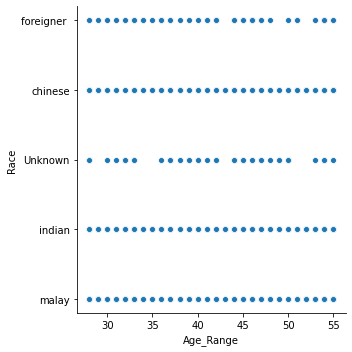

In [133]:
ax = sns.relplot(x="Age_Range", y="Race", data=cluster)

### Elbow analysis

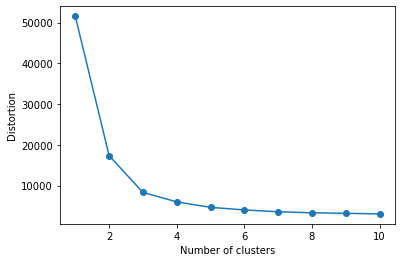

In [134]:
distortions = []

# your codes here...
for i in range(1,11):
    km=KMeans(
        n_clusters=i,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-4,
        random_state=0
    )
    km.fit(cluster_dum)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

##conclusion, use k=2(elbow)

In [135]:
km=KMeans(n_clusters=3,random_state=1)
km.fit(cluster_dum)

cluster_vis=cluster.copy()
cluster_vis['label']=km.labels_



In [136]:
cluster_vis

,Time_Of_Day,Race,Gender,Age_Group,Age_Range,Body_Size,With_Kids,Kids_Category,Basket_Size,label
0,Night,malay,Unknown,"(40, 50]",42,moderate,yes,young,big,1
1,Night,indian,male,"(30, 40]",32,thin,no,no_kids,big,2
2,Night,malay,female,"(20, 30]",30,Unknown,no,no_kids,big,2
3,Night,indian,male,"(50, 60]",51,thin,no,no_kids,Unknown,0
4,Night,indian,male,"(30, 40]",34,moderate,no,no_kids,big,2
...,...,...,...,...,...,...,...,...,...,...
802,Night,malay,female,"(40, 50]",45,moderate,no,no_kids,small,1
803,Night,malay,male,"(30, 40]",34,fat,no,no_kids,big,2
804,Night,malay,female,"(50, 60]",53,moderate,no,no_kids,big,0
805,Night,indian,female,"(30, 40]",37,moderate,no,no_kids,big,2


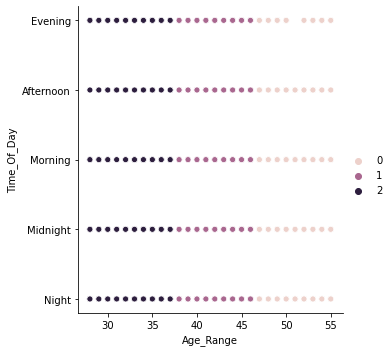

In [138]:
ax = sns.relplot(x="Age_Range", y="Time_Of_Day", hue=cluster_vis.label.tolist(), data=cluster_vis)

# BORUTA

In [59]:
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [102]:
cleaned=(df.pipe(change_to_date)
        .pipe(fill_age)
        .pipe(fill_withKids_yes)
        .pipe(fill_withKids_no)
        .pipe(fill_null_val)
        .pipe(mark_washer)
        .pipe(mark_dryer)
        .pipe(get_month_col)
        .pipe(get_time_of_day)
        .pipe(bin_age)
        .pipe(select_classifier1)
         
    )

In [103]:
cleaned.head(20)

,Time_Of_Day,Race,Gender,Body_Size,With_Kids,Kids_Category,Basket_Size,Basket_colour,Attire,Shirt_Colour,shirt_type,Pants_Colour,pants_type,Wash_Item,Washer_No,Dryer_No
0,Night,malay,Unknown,moderate,yes,young,big,red,casual,blue,short_sleeve,black,short,clothes,W_3,D_10
1,Night,indian,male,thin,no,no_kids,big,green,casual,Unknown,short_sleeve,blue_jeans,long,Unknown,W_6,D_9
2,Night,malay,female,Unknown,no,no_kids,big,blue,casual,red,short_sleeve,black,long,Unknown,W_4,D_10
3,Night,indian,male,thin,no,no_kids,Unknown,black,casual,Unknown,short_sleeve,yellow,short,clothes,W_5,D_9
4,Night,indian,male,moderate,no,no_kids,big,blue,casual,blue,short_sleeve,white,long,clothes,W_3,D_9
5,Night,Unknown,male,fat,no,no_kids,small,white,casual,brown,Unknown,blue_jeans,long,clothes,W_4,D_8
6,Night,Unknown,female,fat,no,no_kids,big,pink,traditional,blue,Unknown,black,long,clothes,W_5,D_10
7,Midnight,indian,male,thin,yes,Unknown,big,blue,casual,Unknown,short_sleeve,brown,long,clothes,W_3,D_9
8,Midnight,indian,male,thin,no,no_kids,small,purple,casual,white,short_sleeve,black,short,clothes,W_6,D_10
9,Midnight,chinese,male,moderate,no,no_kids,small,pink,casual,white,short_sleeve,blue_jeans,short,Unknown,W_5,D_7


In [79]:
cleaned=cleaned.apply(LabelEncoder().fit_transform)

y = cleaned.Basket_Size
X = cleaned.drop("Basket_Size", 1)
colnames = X.columns

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['float', 'str']

In [42]:
rf = RandomForestClassifier(n_jobs=-1,class_weight="balanced",max_depth=5)
feat_selector = BorutaPy(rf, n_estimators="auto",random_state =1)

feat_selector.fit(X.values,y.values.ravel())

boruta_score = ranking(list(map(float, feat_selector.ranking_)), colnames, order=-1)
boruta_score = pd.DataFrame(list(boruta_score.items()), columns=['Features', 'Score'])
boruta_score = boruta_score.sort_values("Score",ascending=False)

In [43]:
# your codes here...
print('---------Top 10----------')
display(boruta_score.head(10))

# your codes here...
print('---------Bottom 10----------')
boruta_score.tail(10)

---------Top 10----------


,Features,Score
6,Basket_colour,1.00
10,Pants_Colour,1.00
0,Race,0.93
3,Age_Range,0.86
7,Attire,0.79
8,Shirt_Colour,0.71
13,Washer_No,0.64
2,Body_Size,0.57
14,Dryer_No,0.57
5,Kids_Category,0.43


---------Bottom 10----------


,Features,Score
13,Washer_No,0.64
2,Body_Size,0.57
14,Dryer_No,0.57
5,Kids_Category,0.43
11,pants_type,0.36
12,Wash_Item,0.36
1,Gender,0.21
15,Age_Group,0.14
9,shirt_type,0.07
4,With_Kids,0.00
